In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
df = pd.read_csv("marketing_dataset.csv")

In [3]:
# OneHot Encoding for categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded = encoder.fit_transform(df[['region', 'channel']])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['region', 'channel']))

In [4]:
# Combine encoded features with numerical ones
df_encoded = pd.concat([df.drop(['region', 'channel', 'row_id'], axis=1), encoded_df], axis=1)

In [5]:
# Select predictor and target
X = df_encoded[['tv_spend']]
y = df_encoded['sales']

In [7]:
# Create Balanced Sample
min_sales, max_sales = y.min(), y.max()
balanced_idx = y.groupby(pd.cut(y, np.linspace(min_sales, max_sales, 6)), observed=False).apply(
    lambda g: g.sample(min(len(g), 30), random_state=42)
).reset_index(level=0, drop=True).index
X_balanced, y_balanced = X.loc[balanced_idx], y.loc[balanced_idx]

In [8]:
# Create Imbalanced Sample
imbalanced_idx = y[y < y.quantile(0.6)].sample(300, random_state=42).index.append(
    y[y >= y.quantile(0.6)].sample(30, random_state=42).index
)
X_imbalanced, y_imbalanced = X.loc[imbalanced_idx], y.loc[imbalanced_idx]

In [9]:
# Train models
model_balanced = LinearRegression().fit(X_balanced, y_balanced)
model_imbalanced = LinearRegression().fit(X_imbalanced, y_imbalanced)

In [10]:
# Predictions
y_pred_balanced = model_balanced.predict(X_balanced)
y_pred_imbalanced = model_imbalanced.predict(X_imbalanced)

In [11]:
# Evaluation metrics
def print_metrics(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{label} Data Metrics:")
    print(f"MAE:  {mae:.2f}")
    print(f"MSE:  {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.4f}")

In [12]:
print_metrics(y_balanced, y_pred_balanced, "Balanced")
print_metrics(y_imbalanced, y_pred_imbalanced, "Imbalanced")


Balanced Data Metrics:
MAE:  82.84
MSE:  11872.05
RMSE: 108.96
R²:   0.0316

Imbalanced Data Metrics:
MAE:  26.18
MSE:  1660.34
RMSE: 40.75
R²:   0.0000


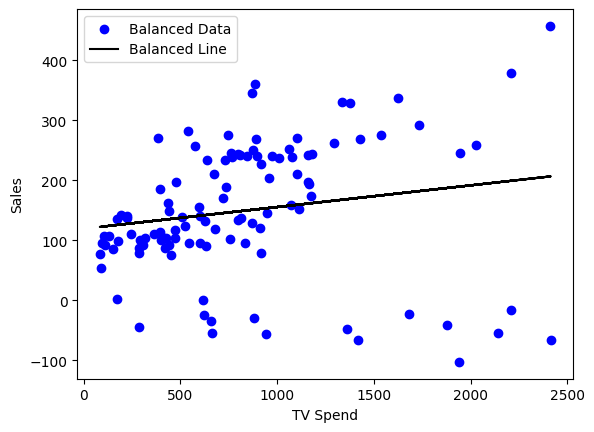

In [13]:
# Plot Balanced
plt.scatter(X_balanced, y_balanced, color='blue', label='Balanced Data')
plt.plot(X_balanced, y_pred_balanced, color='black', label='Balanced Line')
plt.xlabel("TV Spend")
plt.ylabel("Sales")
plt.legend()
plt.show()

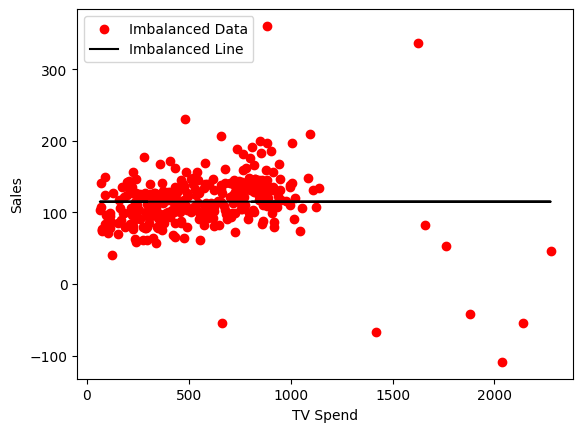

In [14]:
# Plot Imbalanced
plt.scatter(X_imbalanced, y_imbalanced, color='red', label='Imbalanced Data')
plt.plot(X_imbalanced, y_pred_imbalanced, color='black', label='Imbalanced Line')
plt.xlabel("TV Spend")
plt.ylabel("Sales")
plt.legend()
plt.show()